### Import Neccesary Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import os, sys, json, textwrap, math
import xgboost as xgb
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings("ignore")

In [54]:
OUT_DIR = Path("C:/Users/DELL/flask")  # change if needed
OUT_DIR.mkdir(parents=True, exist_ok=True)
file_path = "C:/Users/DELL/flask/financial_loan Datasets and Description__.xlsx"
print("Out dir:", OUT_DIR)


Out dir: C:\Users\DELL\flask


### Load sheets & quick overview

In [3]:
xls = pd.ExcelFile(file_path)
print("Sheets available:", xls.sheet_names)
# pick the best candidate sheet automatically
sheet_main = None
for s in xls.sheet_names:
    if "financial" in s.lower() or "loan" in s.lower():
        sheet_main = s
        break
if sheet_main is None:
    sheet_main = xls.sheet_names[0]
print("Using sheet:", sheet_main)
data = pd.read_excel(xls, sheet_name=sheet_main)
df = data.copy()
print("Shape:", df.shape)
df.head()

Sheets available: ['financial_loan Datasets and Des', 'Descriptions']
Using sheet: financial_loan Datasets and Des
Shape: (38576, 24)


,id,address_state,application_type,emp_length,emp_title,grade,home_ownership,issue_date,last_credit_pull_date,last_payment_date,...,sub_grade,term,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment
0,1077430,GA,INDIVIDUAL,< 1 year,Ryder,C,RENT,2021-11-02 00:00:00,13-09-2021,13-04-2021,...,C4,60 months,Source Verified,30000.0,0.0100,59.83,0.1527,2500,4,1009
1,1072053,CA,INDIVIDUAL,9 years,MKC Accounting,E,RENT,2021-01-01 00:00:00,14-12-2021,15-01-2021,...,E1,36 months,Source Verified,48000.0,0.0535,109.43,0.1864,3000,4,3939
2,1069243,CA,INDIVIDUAL,4 years,Chemat Technology Inc,C,RENT,2021-05-01 00:00:00,2021-12-12 00:00:00,2021-09-01 00:00:00,...,C5,36 months,Not Verified,50000.0,0.2088,421.65,0.1596,12000,11,3522
3,1041756,TX,INDIVIDUAL,< 1 year,barnes distribution,B,MORTGAGE,25-02-2021,2021-12-12 00:00:00,2021-12-03 00:00:00,...,B2,60 months,Source Verified,42000.0,0.0540,97.06,0.1065,4500,9,4911
4,1068350,IL,INDIVIDUAL,10+ years,J&J Steel Inc,A,MORTGAGE,2021-01-01 00:00:00,14-12-2021,15-01-2021,...,A1,36 months,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835


### Inspect columns, types, missing

In [4]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (38576, 24)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38576 entries, 0 to 38575
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     38576 non-null  int64  
 1   address_state          38576 non-null  object 
 2   application_type       38576 non-null  object 
 3   emp_length             38576 non-null  object 
 4   emp_title              37138 non-null  object 
 5   grade                  38576 non-null  object 
 6   home_ownership         38576 non-null  object 
 7   issue_date             38576 non-null  object 
 8   last_credit_pull_date  38576 non-null  object 
 9   last_payment_date      38576 non-null  object 
 10  loan_status            38576 non-null  object 
 11  next_payment_date      38576 non-null  object 
 12  member_id              38576 non-null  int64  
 13  purpose                38576 non-null  object 
 14  sub_grade              38576 non-null  object 
 15  te

### Data Cleaning & Type Conversion
We fix the data types. Dates are strings, and terms/employment lengths have text mixed with numbers.

In [6]:
def clean_loan_data(data):
    df_clean = data.copy()
    
    #  Date Conversion
    date_cols = ['issue_date', 'last_credit_pull_date', 'last_payment_date', 'next_payment_date']
    for col in date_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    # Numeric Extraction from Strings
    # 'term' (e.g., " 36 months" -> 36)
    if 'term' in df_clean.columns:
        df_clean['term'] = df_clean['term'].astype(str).str.extract('(\d+)').astype(float)
    
    # 'emp_length' (e.g., "< 1 year" -> 0, "10+ years" -> 10)
    if 'emp_length' in df_clean.columns:
        df_clean['emp_length'] = df_clean['emp_length'].astype(str).str.extract('(\d+)').astype(float)
    
    return df_clean

df = clean_loan_data(df)

### Handling Missing Values

*Strategy:*
- 'emp_length': Missing likely means unemployed or self-employed without verification. Fill with 0.
- 'dti', 'annual_income': Critical financial metrics. If missing, fill with Median (robust to outliers).
- 'emp_title': High cardinality text. Fill with "Unknown".

A General strategy to deal with mising values for Categorical and numerical ariable in the dataset if they exist is using a combination of Mode for categorical features and Median for numerical features.

In [7]:
# missing summary
missing = df.isnull().sum().sort_values(ascending=False)
display(missing[missing>0].head(24))

emp_title    1438
dtype: int64

In [8]:
missing_percent = df.isnull().mean() * 100
print("Missing Value Percentage per Column:\n", missing_percent[missing_percent > 0])

# Execution
df['emp_length'].fillna(0, inplace=True)
df['emp_title'].fillna('Unknown', inplace=True)

# Note: Other numerical missing values (like total_acc) will be handled 
# by the SimpleImputer inside our ML pipeline later to prevent data leakage.
print("\nSpecific manual imputations complete.")

Missing Value Percentage per Column:
 emp_title    3.727706
dtype: float64

Specific manual imputations complete.


## Target creation

##### To Create Target Variable we must define "Bad" loan statuses
We are building a model to predict 'Approval' (Good Credit Risk).
- 1 = Approved (Fully Paid, Current)
- 0 = Rejected (Charged Off, Default)


In [9]:
good_status = ['Fully Paid', 'Current']
bad_status = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off']

# Filter only definitive rows
df= df[df['loan_status'].isin(good_status + bad_status)].copy()

# Create binary target
df['loan_approved'] = df['loan_status'].apply(lambda x: 1 if x in good_status else 0)

# Check for class imbalance
print("Target distribution:")
print(df['loan_approved'].value_counts(normalize=True))

Target distribution:
loan_approved
1    0.861753
0    0.138247
Name: proportion, dtype: float64


In [10]:
df['loan_status'].unique()

array(['Charged Off', 'Fully Paid', 'Current'], dtype=object)

Observation: There is a significant class imbalance (approx. 86% - 1 vs. 14% - 0). This will require careful model evaluation (e.g., using Recall and Precision).

## Robust Exploraatory Data Analysis

In [11]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ('id','member_id','target')]  # drop ID and Member ID
print("Numeric columns:", num_cols[:30])

# numeric summary
num_desc = df[num_cols].describe().T
display(num_desc)

Numeric columns: ['emp_length', 'term', 'annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment', 'loan_approved']


,count,mean,std,min,25%,50%,75%,max
emp_length,38576.0,5.093426,3.408560,1.0000,2.0000,4.0000,9.0000,1.000000e+01
term,38576.0,42.432393,10.630366,36.0000,36.0000,36.0000,60.0000,6.000000e+01
annual_income,38576.0,69644.540310,64293.681045,4000.0000,41500.0000,60000.0000,83200.5000,6.000000e+06
dti,38576.0,0.133274,0.066662,0.0000,0.0821,0.1342,0.1859,2.999000e-01
installment,38576.0,326.862965,209.092000,15.6900,168.4500,283.0450,434.4425,1.305190e+03
int_rate,38576.0,0.120488,0.037164,0.0542,0.0932,0.1186,0.1459,2.459000e-01
loan_amount,38576.0,11296.066855,7460.746022,500.0000,5500.0000,10000.0000,15000.0000,3.500000e+04
total_acc,38576.0,22.132544,11.392282,2.0000,14.0000,20.0000,29.0000,9.000000e+01
total_payment,38576.0,12263.348533,9051.104777,34.0000,5633.0000,10042.0000,16658.0000,5.856400e+04
loan_approved,38576.0,0.861753,0.345163,0.0000,1.0000,1.0000,1.0000,1.000000e+00


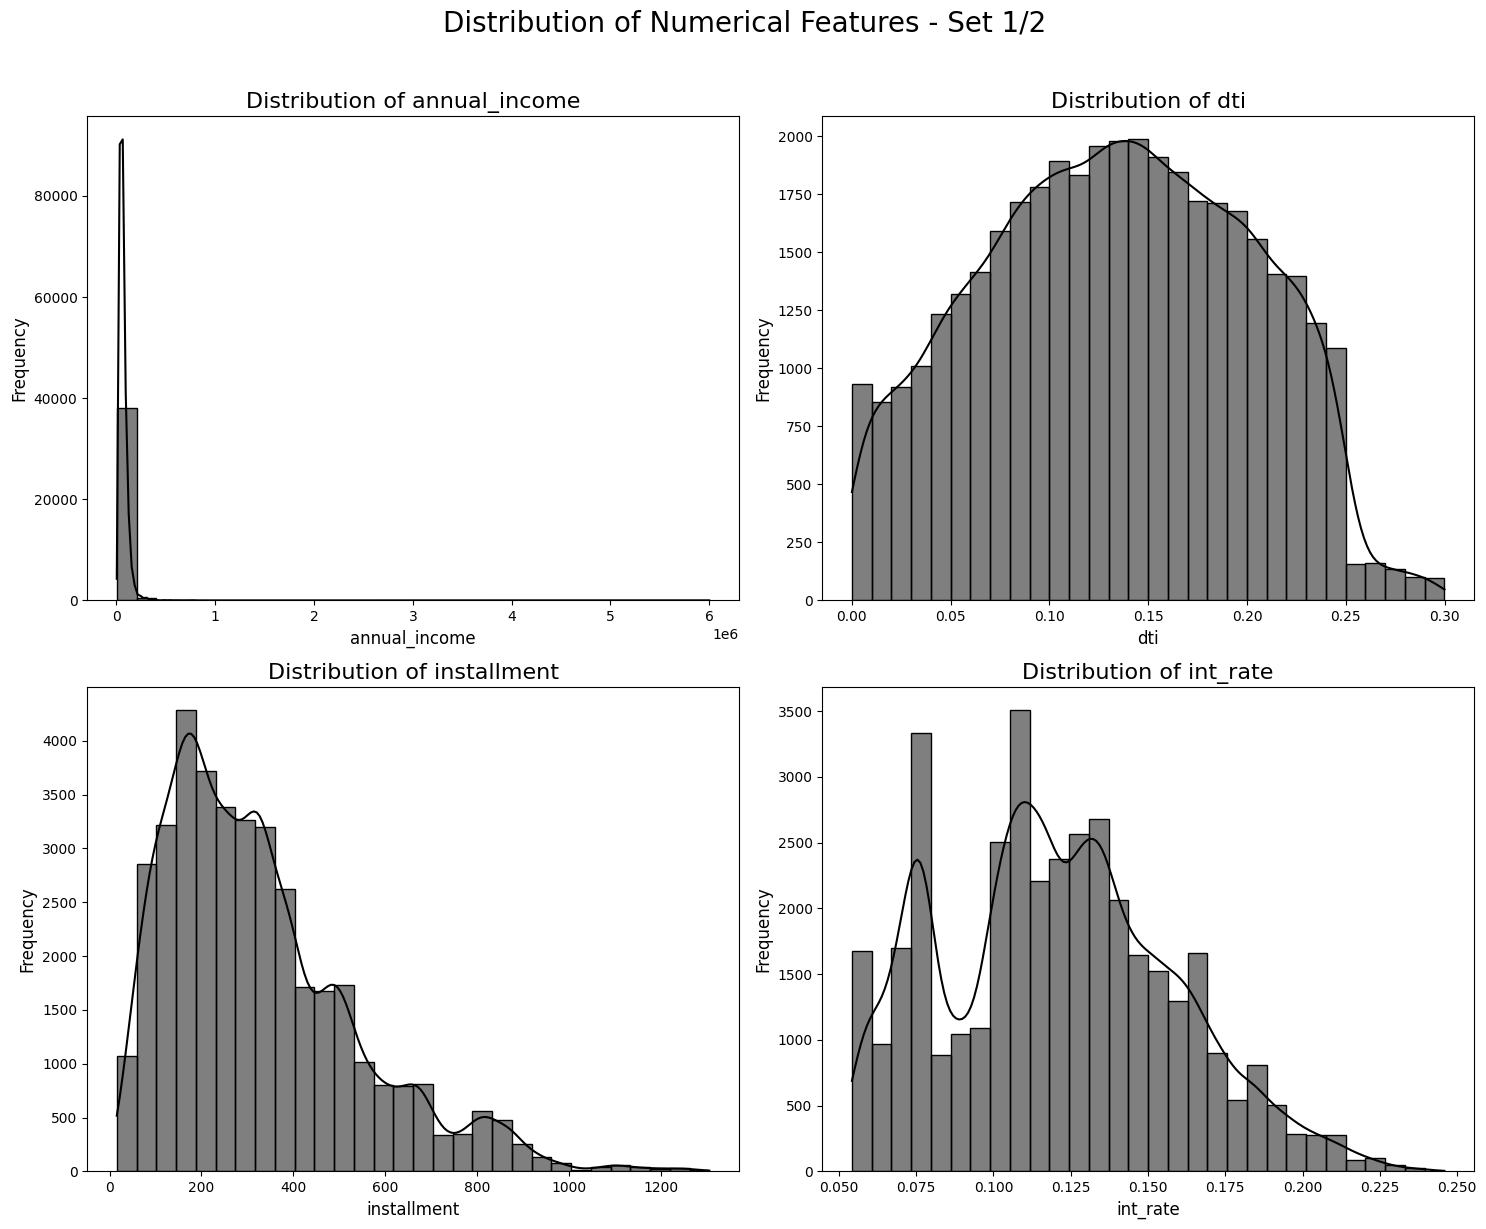

In [12]:
numerical_cols = ['annual_income', 'dti', 'installment', 'int_rate', 'loan_amount', 'total_acc', 'total_payment']
first_four_cols = numerical_cols[:4]

plt.figure(figsize=(15, 12)) # Adjusted size for 2x2 grid

for i, col in enumerate(first_four_cols):
    # Grid: 2 rows, 2 columns
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='black')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.suptitle('Distribution of Numerical Features - Set 1/2', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

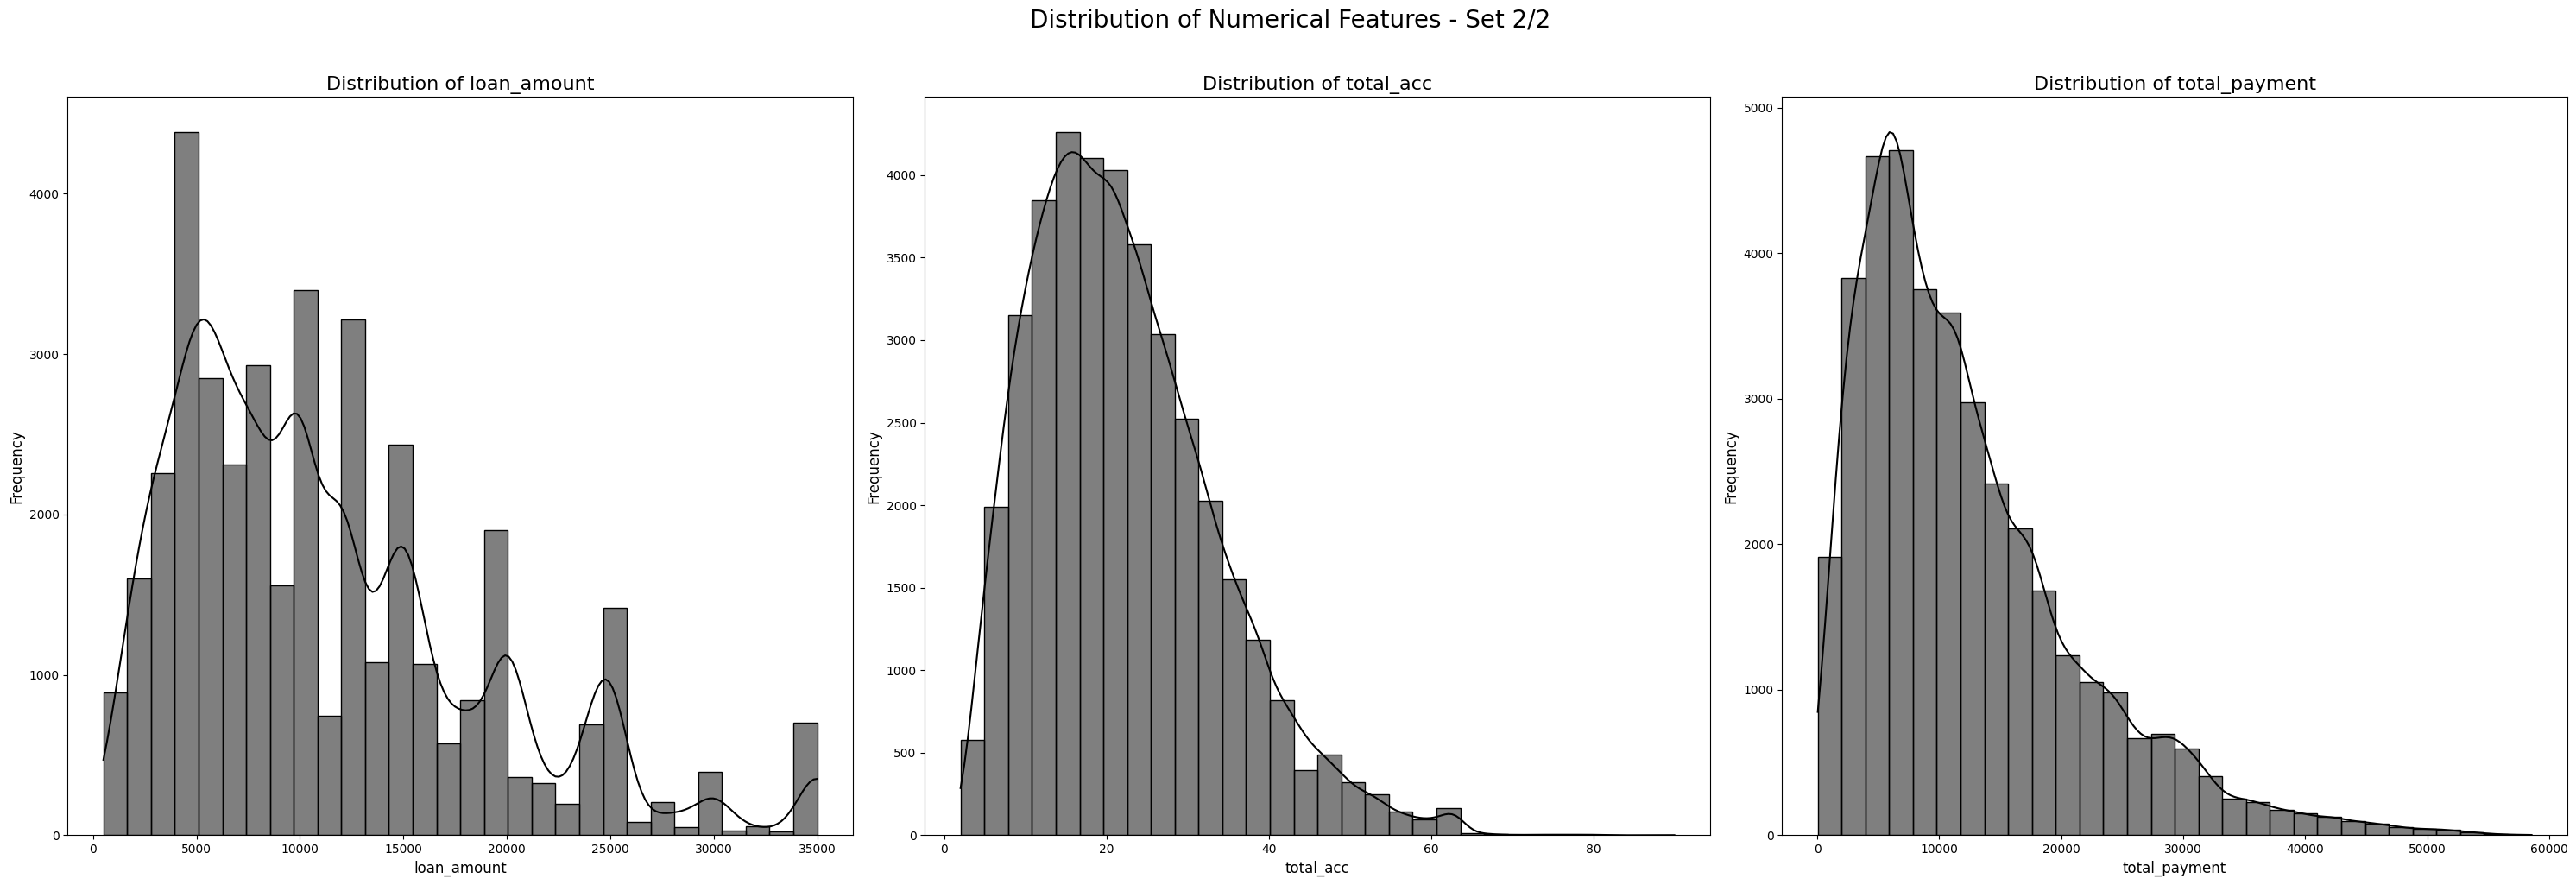

In [42]:
remaining_cols = numerical_cols[4:]

plt.figure(figsize=(30, 10)) # Consistent size (2x2)

for i, col in enumerate(remaining_cols):
    # Grid: 2 rows, 2 columns
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30, color='black')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.suptitle('Distribution of Numerical Features - Set 2/2', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

## Summary Insights: Numerical Feature Distributions

The analysis of the numerical feature distributions reveals three primary characteristics crucial for data preprocessing and modeling:

---

### 1. Extreme Skewness and Outliers 

* **Observation:** Features like **annual\_income**, **total\_payment**, and **total\_acc** are highly **right-skewed**, meaning most data points are concentrated at the low end, with long tails stretching toward high values.
* **Implication:** This skewness often indicates the presence of significant **outliers** (especially in `annual_income`). For linear models, these features will likely require a **logarithmic transformation** to normalize the distribution and improve model performance.

---

### 2. Clustering and Multimodality

* **Observation:** The **int\_rate** and **loan\_amount** distributions exhibit **multimodality** (multiple distinct peaks).
    * `int_rate` shows peaks suggesting specific risk tiers (e.g., low vs. moderate/high rates).
    * `loan_amount` shows peaks at common, rounded values (e.g., \$5k, \$10k, \$20k).
* **Implication:** These variables may be driven by underlying **categorical policies or product offerings**. This suggests that either **feature engineering** (like creating bins or dummy variables) or investigating the original categorical source might be beneficial for modeling.

---

### 3. Central Tendency 

* **Observation:** Features like **dti** show a relatively uniform or central distribution, while **installment** and **total\_acc** have clear peaks near their respective averages (e.g., installments are most common below \$400, total accounts around 15-20).
* **Implication:** These features are generally well-behaved, though the heavy concentration of `installment` near zero may still warrant attention to prevent undue influence on the model.

In [14]:
# Target vs numeric: group mean difference
diffs = []
for c in num_cols:
    try:
        diff = df.groupby('loan_approved')[c].mean().diff().iloc[-1]
        diffs.append((c, diff, df[c].isnull().mean()))
    except Exception:
        pass
diffs_sorted = sorted(diffs, key=lambda x: abs(x[1]), reverse=True)
pd.DataFrame(diffs_sorted, columns=['feature','mean_diff(target=1 - target=0)','pct_missing']).head(20)

,feature,mean_diff(target=1 - target=0),pct_missing
0,annual_income,7112.025215,0.0
1,total_payment,6117.780770,0.0
2,loan_amount,-1151.133620,0.0
3,installment,-16.147439,0.0
4,term,-4.599061,0.0
5,loan_approved,1.000000,0.0
6,total_acc,0.649702,0.0
7,emp_length,-0.135943,0.0
8,int_rate,-0.021233,0.0
9,dti,-0.007860,0.0


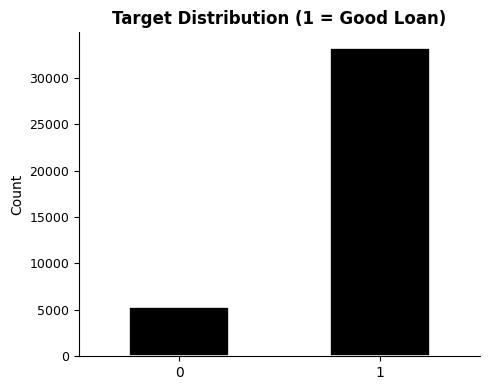

In [15]:
# Target Distribution (Styled)
plt.figure(figsize=(5, 4))

# Plot as simple + clean
ax = df['loan_approved'].value_counts().sort_index().plot(
    kind='bar',
    color='black',
    edgecolor='white',
    linewidth=1.2
)

# Titles & labels kept minimal but elegant
plt.title("Target Distribution (1 = Good Loan)", fontsize=12, weight='bold')
plt.xlabel("")
plt.ylabel("Count", fontsize=10)

# Cleaner axis look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


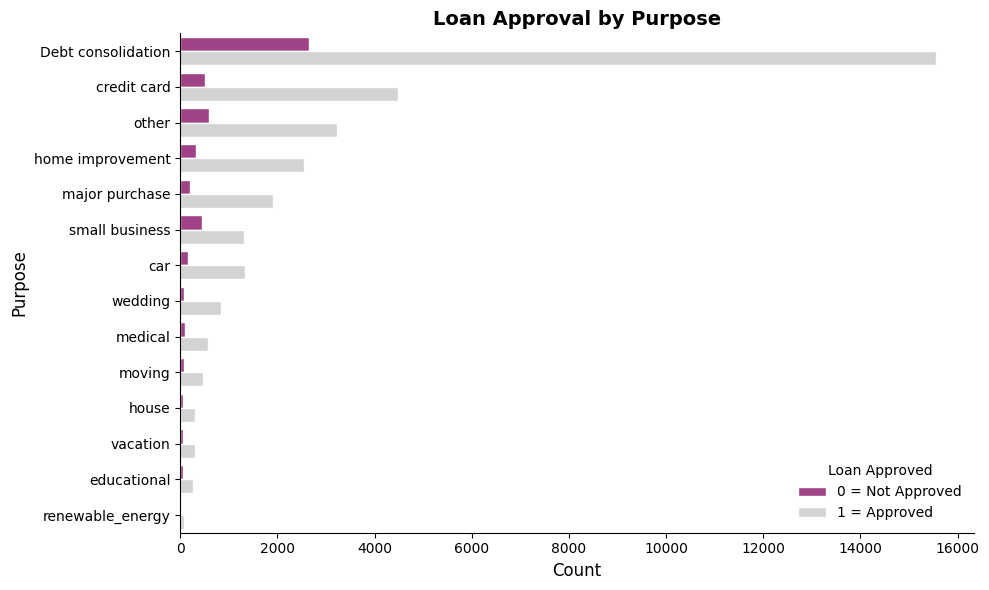

In [16]:
plt.figure(figsize=(10, 6))

# Sort purpose categories by frequency for readability
order = df['purpose'].value_counts().index

sns.countplot(
    data=df,
    y='purpose',
    hue='loan_approved',
    order=order,
    palette=['#AE328E', 'lightgray'],   # black for 0, gray for 1
    edgecolor='white'
)

plt.title('Loan Approval by Purpose', fontsize=14, weight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Purpose', fontsize=12)

plt.legend(
    title='Loan Approved',
    labels=['0 = Not Approved', '1 = Approved'],
    frameon=False
)

# Make it cleaner
sns.despine(left=False, bottom=False)

plt.tight_layout()
plt.show()


# Loan Approval by Purpose

The horizontal bar chart above displays the count of loan applications for various purposes, segmented by whether the loan was **Approved (1)** or **Not Approved (0)**.

* **Grey Bars:** Approved Loans (1)
* **Purple Bars:** Not Approved Loans (0)

### Key Observations

**1. Dominance of Debt Consolidation**
* **Highest Volume:** "Debt consolidation" is by far the most common reason for applying for a loan. The volume of approved loans for this category (grey bar) exceeds 15,000, dwarfing all other categories combined.
* **Rejection Volume:** It also has the highest absolute number of rejections (purple bar), which is expected given the sheer volume of applications.

**2. Other Significant Categories**
* **Credit Card:** This is the second most common purpose, with roughly 4,500 approved loans.
* **Home Improvement & Major Purchase:** These follow as mid-tier categories.

**3. Small Business Risk**
* **Visual Ratio:** While "Debt consolidation" has a huge gap between approvals and rejections, the "Small Business" category appears to have a relatively larger proportion of purple (rejections) compared to its grey bar than some other categories. This suggests that **small business loans might be riskier** or harder to get approved compared to consumer loans like weddings or cars.

**4. Niche Categories**
* Categories like "renewable_energy," "educational," and "vacation" represent a tiny fraction of the portfolio, with very low application counts.

---

### Summary for Analysis
The dataset is heavily skewed towards **Debt Consolidation**.
* **Modeling Implication:** If you use "Purpose" as a categorical feature, the model might be biased towards debt consolidation simply due to frequency. Consider grouping smaller categories (like vacation, moving, renewable_energy) into a single "Other" bucket to reduce cardinality and improve model stability.

#### Loan Volume by Credit Grade

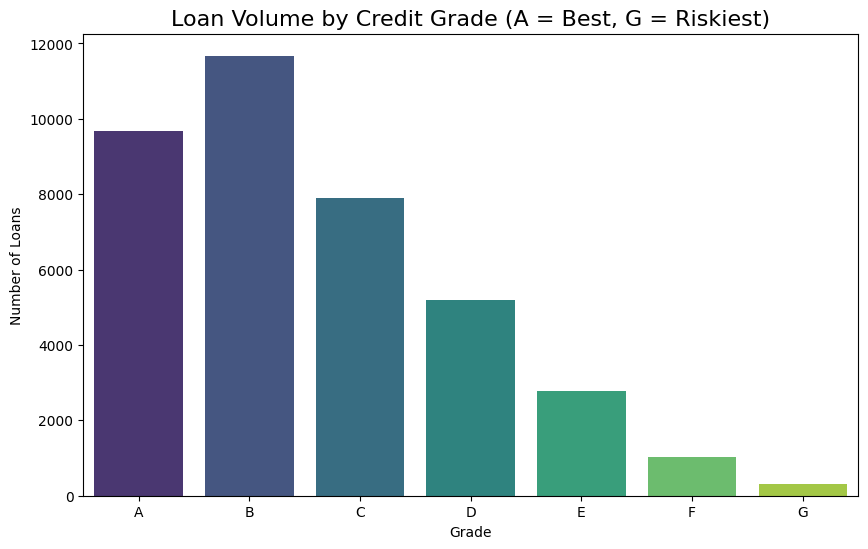

In [17]:
plt.figure(figsize=(10, 6))

# Sort grades alphabetically so A comes before G
order_grade = sorted(df['grade'].unique())
sns.countplot(x='grade', data=df, order=order_grade, palette='viridis')

plt.title('Loan Volume by Credit Grade (A = Best, G = Riskiest)', fontsize=16)
plt.xlabel('Grade')
plt.ylabel('Number of Loans')
plt.show()

# Loan Volume by Credit Grade

The bar chart above visualizes the distribution of the total number of loans issued across different credit grades, where **Grade A** represents the lowest risk (best credit) and **Grade G** represents the highest risk.

### Key Observations

**1. Concentration in Prime and Near-Prime Grades**
* **Dominance of Grade B:** The tallest bar corresponds to **Grade B**, with nearly 12,000 loans. This suggests the lending portfolio is most heavily weighted towards "near-prime" borrowers—those with good credit but perhaps not perfect.
* **Strong Grade A Presence:** **Grade A** (the safest tier) is the second most common category, with just under 10,000 loans.
* **Combined Volume:** Together, Grades A, B, and C account for the vast majority of the loan volume. This indicates a relatively conservative lending strategy focused on lower-risk borrowers.

**2. Decline in High-Risk Loans**
* **Steep Drop-off:** There is a consistent, stair-step decline in volume as risk increases from Grade C through Grade G.
* **Minimal Exposure to Grade G:** The volume of loans in **Grade G** (the riskiest category) is negligible compared to the others, appearing to be fewer than 500 loans. This reflects a strict risk appetite where very few high-risk applicants are approved.

---

### Summary for Analysis
The dataset is **imbalanced** with respect to credit grade. Any machine learning model trained on this data will see far more examples of "good" borrowers (Grades A/B) than "risky" borrowers (Grades F/G).

**Modeling Implication:** You may need to use techniques like **oversampling (SMOTE)**, **class weights**, or **stratified sampling** to ensure your model learns to correctly identify patterns in the rarer, high-risk categories (F and G), rather than just overfitting to the dominant Grades A and B.

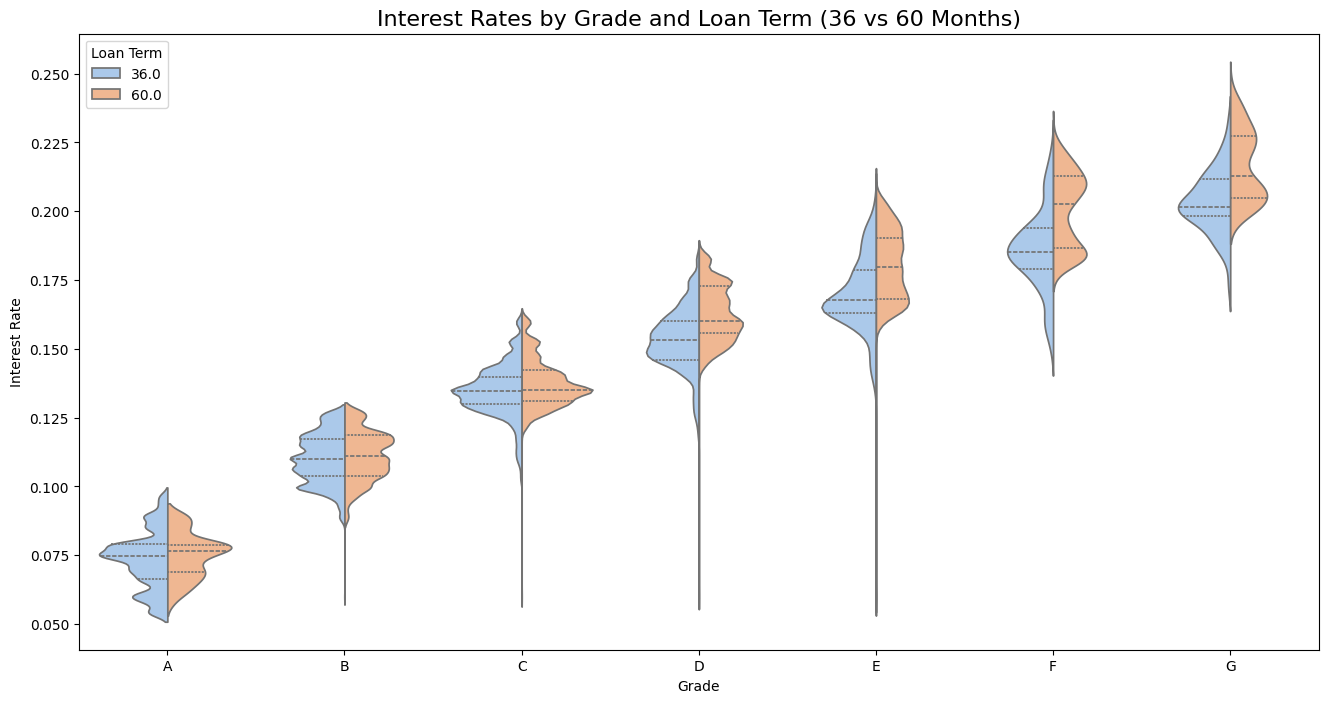

In [18]:
plt.figure(figsize=(16, 8))

sns.violinplot(x="grade", y="int_rate", hue="term",
               data=df, split=True, inner="quart", palette="pastel",
               order=['A','B','C','D','E','F','G'])

plt.title('Interest Rates by Grade and Loan Term (36 vs 60 Months)', fontsize=16)
plt.xlabel('Grade')
plt.ylabel('Interest Rate')
plt.legend(title='Loan Term')
plt.show()

# Interest Rates by Grade and Loan Term (36 vs 60 Months)

The violin plot above compares the distribution of **interest rates** across different credit **Grades** (A through G), split by **Loan Term** (36 months vs. 60 months).

* **Blue (Left):** 36-month loans.
* **Orange (Right):** 60-month loans.
* **Shape:** The width of the "violin" represents the density of loans at that specific interest rate.

### Key Observations

**1. The "Step-Ladder" Effect (Grade Impact)**
* **Trend:** There is a distinct, upward progression in interest rates as you move from Grade A to Grade G.
    * **Grade A:** Lowest rates, concentrated around 6-8%.
    * **Grade G:** Highest rates, concentrated around 20-25%.
* **Insight:** This confirms that **Grade** is the primary determinant of the base interest rate. The bands are clearly separated, with minimal overlap between non-adjacent grades.

**2. The Term Premium (36 vs. 60 Months)**
* **Visual Evidence:** Within almost every grade (especially visible in Grades B, C, D, and E), the orange side (60-month) is shifted slightly **higher** than the blue side (36-month).
* **Insight:** Borrowers pay a premium for longer terms. If two borrowers have the exact same credit grade (e.g., Grade C), the one choosing a 5-year loan (60 months) will typically pay a higher interest rate than the one choosing a 3-year loan (36 months), likely to compensate for the extended risk exposure over time.

**3. Distribution Shape**
* **Tightness:** Lower grades (A, B) have wider, shorter violins, indicating that interest rates are tightly clustered around a specific value.
* **Spread:** Higher grades (F, G) have thinner, taller violins. This suggests more variability or "negotiation" in the interest rates for high-risk borrowers; the rates are less standardized compared to prime borrowers.

---

### Summary for Analysis
Interest rates are determined by a clear two-factor hierarchy:
1.  **Credit Grade** (The primary tier).
2.  **Loan Term** (A secondary upward adjustment within that tier).

When modeling, you can expect `int_rate` to be highly collinear with `grade`, but adding `term` as a feature will capture the subtle variance within each grade level.

### Correlation

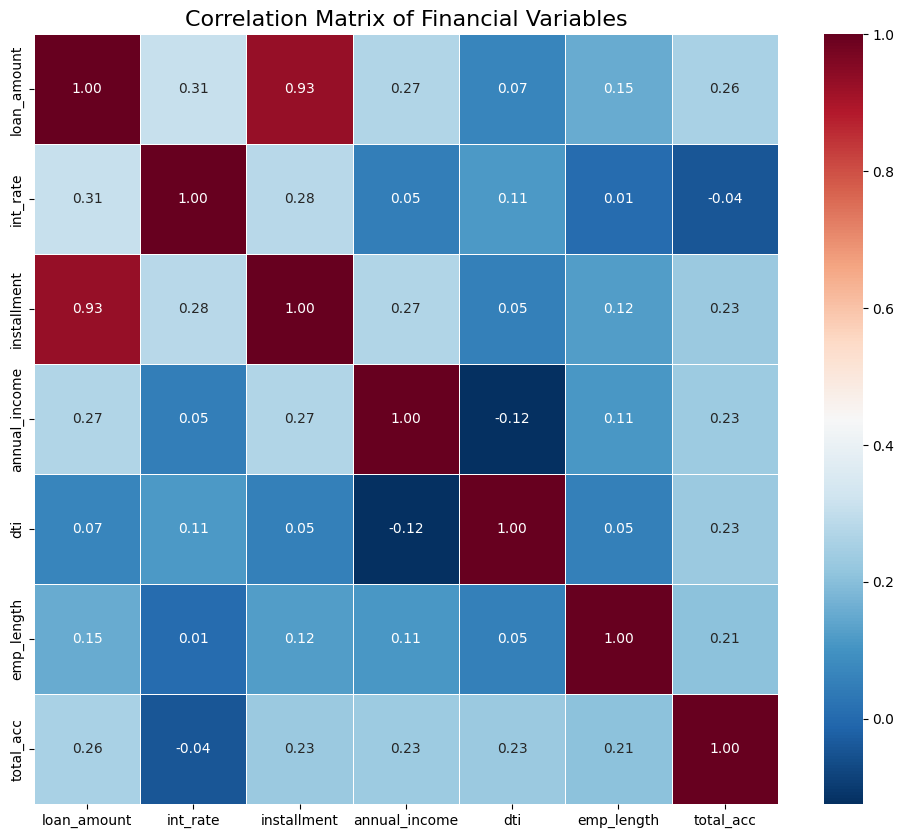

In [19]:
# Select only numeric columns for correlation
numeric_cols = ['loan_amount', 'int_rate', 'installment', 'annual_income', 'dti', 'emp_length', 'total_acc']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Financial Variables', fontsize=16)
plt.show()

# Analysis of Financial Variables Correlation Matrix

The heatmap above displays the correlation coefficients between various financial variables in the dataset. Correlation coefficients range from **-1 to 1**, indicating the strength and direction of the relationship between two variables.

### Key Observations

**1. Strong Positive Correlation**
* **Loan Amount vs. Installment ($0.93$):** There is an extremely strong positive correlation between `loan_amount` and `installment`. This is expected, as higher loan amounts naturally result in higher monthly installment payments.
* **Loan Amount vs. Interest Rate ($0.31$):** There is a moderate positive correlation. Larger loans tend to carry slightly higher interest rates, likely due to increased risk.

**2. Moderate Positive Correlations**
* **Annual Income vs. Loan Amount ($0.27$) & Installment ($0.27$):** Borrowers with higher annual incomes tend to qualify for larger loans and higher installments.
* **Total Accounts vs. Loan Amount ($0.26$):** There is a weak-to-moderate link suggesting that people with more credit lines (`total_acc`) tend to have slightly larger loan amounts.

**3. Weak or Negligible Correlations**
* **Interest Rate vs. Annual Income ($0.05$):** There is almost no correlation here, suggesting that a borrower's income level does not strongly dictate the interest rate they receive.
* **DTI (Debt-to-Income) vs. Loan Amount ($0.07$):** The size of the loan does not seem to be strongly related to the borrower's debt-to-income ratio.

**4. Negative Correlation**
* **DTI vs. Annual Income ($-0.12$):** There is a slight negative correlation. This indicates that as annual income increases, the debt-to-income ratio tends to decrease slightly, which makes sense as higher income can offset debt levels.

---

### Conclusion for Modeling

> **Multicollinearity Risk:** The variable `installment` is highly redundant with `loan_amount` ($0.93$ correlation). If you are building a regression model, you should consider **dropping one of these features** to avoid multicollinearity, which can skew coefficient estimates and reduce model interpretability.

> **Feature Selection:** Variables like `emp_length` (employment length) generally show weak correlations with other financial metrics, implying it might provide independent information or, conversely, might not be a strong predictor for these specific financial outcomes.

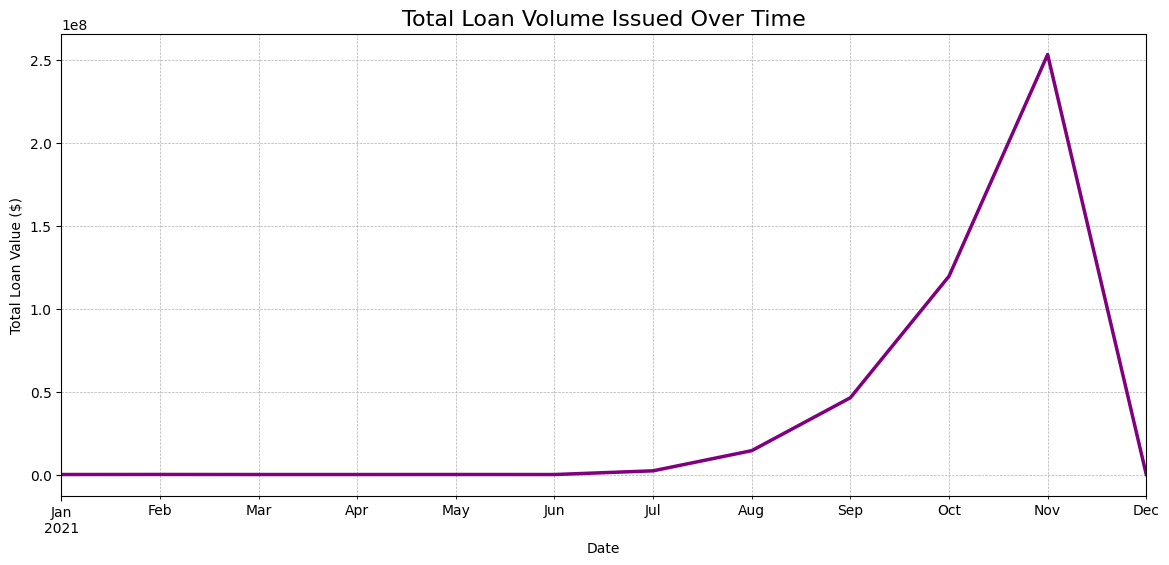

In [20]:
# Resample data by month to smooth out the noise
df.set_index('issue_date', inplace=True)
monthly_volume = df.resample('M')['loan_amount'].sum()

plt.figure(figsize=(14, 6))
monthly_volume.plot(color='purple', linewidth=2.5)
plt.title('Total Loan Volume Issued Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Loan Value ($)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Reset index so we don't break other plots
df.reset_index(inplace=True)

# Analysis of Total Loan Volume Issued Over Time

The time series plot visualizes the total loan volume (in USD) issued throughout the year 2021.

### Key Observations

**1. Stable Low Volume (Jan - Jun)**
* For the first half of the year (January through June), the loan volume is effectively flat and near zero. This suggests a period of inactivity, a pre-launch phase, or very limited operations.

**2. Growth Phase (Jul - Sep)**
* Starting in **July**, there is a slight uptick in volume.
* Growth continues steadily through **August** and **September**, reaching approximately **$50 million** by the end of the third quarter.

**3. Exponential Spike (Oct - Nov)**
* The most significant trend occurs in Q4.
* Volume surges in **October** to over **$100 million**.
* The peak is reached in **November**, with a total loan volume hitting approximately **$250 million**. This sharp increase indicates a major scaling event, successful marketing, or a seasonal demand spike.

**4. Sharp Decline (Dec)**
* Immediately following the peak, the volume drops precipitously in **December**, returning to near-zero levels.
* *Note: This sudden drop often indicates incomplete data for the final month or a strategic pause in lending.*

---

### Summary
The dataset exhibits a **"hockey stick" growth curve** peaking in November 2021, followed by an abrupt drop-off. Any forecasting models should account for the inactivity in H1 and investigate the anomaly in December.

In [21]:
# Create Income Buckets for better segmentation
df['income_bin'] = pd.qcut(df['annual_income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

In [22]:
import plotly.express as px  # Import plotly.express for plotting
import plotly.io as pio      # Keep this if you need to set renderers
from scipy import stats

In [23]:
pio.renderers.default = "notebook_connected"
fig = px.scatter_matrix(df, 
                        dimensions=['annual_income', 'loan_amount', 'int_rate'],
                        color='grade',
                        symbol='loan_approved',
                        title="2D Scatter Matrix: Income vs Loan vs Rate",
                        labels={'target': 'Default?'},
                        opacity=0.6)

fig.update_traces(diagonal_visible=False) # Remove diagonal histograms to keep it clean
fig.update_layout(height=800, width=1000)
fig.show()

# 2D Scatter Matrix: Income vs. Loan Amount vs. Interest Rate

This scatter matrix visualizes the pairwise relationships between `annual_income`, `loan_amount`, and `int_rate`. The data points are color-coded by **Grade** (A through G), which acts as a credit risk category.

### Key Observations

**1. Distinct Stratification by Grade (Interest Rate vs. Loan Amount)**
* **Visual Evidence:** In the plot at the **bottom-middle** (Interest Rate on Y, Loan Amount on X) and **middle-right** (Loan Amount on Y, Interest Rate on X), clear horizontal bands of color are visible.
* **Insight:** There is a direct, tiered relationship between **Grade** and **Interest Rate**.
    * **Grade A (Purple):** Occupies the lowest interest rate band (approx. 5% - 8%).
    * **Grade B (Green):** Occupies the next band up.
    * **Grades C-G (Orange/Pink):** Progressively occupy higher interest rate bands, with Grade G peaking near 25%.
* **Conclusion:** The "Grade" assigned to a borrower is the primary determinant of their interest rate, regardless of the loan size.

**2. Income Distribution and Outliers**
* **Visual Evidence:** The plots involving `annual_income` (left column and top row) show a heavy concentration of data points near 0.
* **Insight:** The income distribution is highly right-skewed. While the vast majority of borrowers earn less than $200k, there are significant outliers earning up to $6M. These outliers generally appear to have lower interest rates (indicated by the purple/blue dots), suggesting high-income earners often qualify for better grades (Grade A/B).

**3. Loan Amount Distribution**
* **Visual Evidence:** In the `loan_amount` vs `int_rate` plots, the data is spread across the entire x-axis.
* **Insight:** Borrowers of all risk grades (colors) take out loans of all sizes. You can see "high risk" (Pink/Orange) loans at both small ($5k) and large ($35k) amounts, just as you can see "low risk" (Purple) loans at both sizes. This implies that loan size alone is not the sole factor in determining risk grade.

---

### Summary for Analysis
The strongest signal in this chart is the **risk-based pricing model**. The distinct color banding confirms that the `int_rate` is strictly segmented by the `grade` variable. When modeling, note that `grade` and `int_rate` will likely share high mutual information.

## Krustal-Wallis H-statistic

automatically checks if the difference in interest rates between "Good" and "Bad" loans is actually significant.

In [24]:
def automated_stat_test(df, num_col, cat_col):
    groups = [df[df[cat_col] == c][num_col] for c in df[cat_col].unique()]

    # Kruskal-Wallis H-test (Non-parametric, robust to outliers)
    stat, p = stats.kruskal(*groups)

    print(f"--- Analyzing {num_col} by {cat_col} ---")
    print(f"Kruskal-Wallis H-statistic: {stat:.2f}")
    print(f"P-Value: {p:.4e}")

    if p < 0.05:
        print(">> RESULT: Statistically Significant Difference Detected.")
    else:
        print(">> RESULT: No significant difference found.")

# Run the test
automated_stat_test(df, 'int_rate', 'loan_status')

--- Analyzing int_rate by loan_status ---
Kruskal-Wallis H-statistic: 2187.72
P-Value: 0.0000e+00
>> RESULT: Statistically Significant Difference Detected.


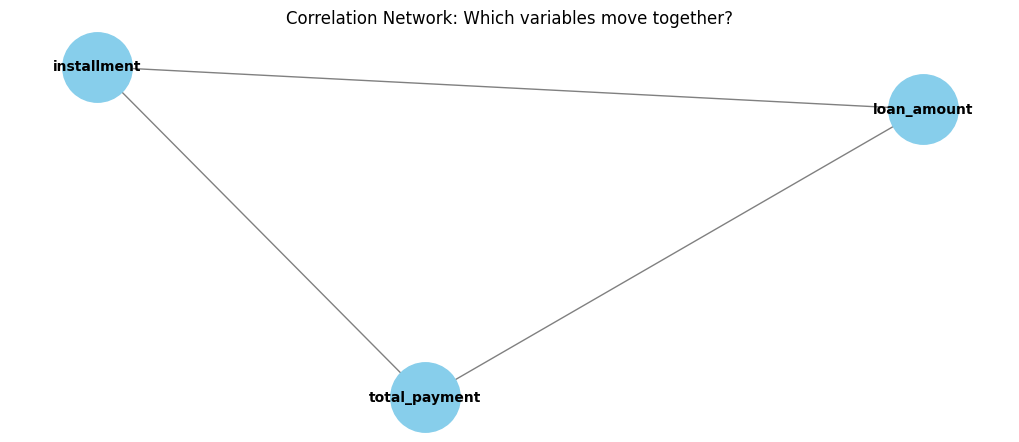

In [25]:
import networkx as nx

# Calculate correlation matrix
corr = df.drop(columns=['member_id', 'id']).select_dtypes(include=[np.number]).corr()

# Transform into a format NetworkX can read (Edge List)
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Filter for strong correlations only (> 0.5) to keep the graph readable
links_filtered = links.loc[(links['value'] > 0.5) & (links['var1'] != links['var2'])]

# Build the graph
G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')

# Plot
plt.figure(figsize=(10, 4))
pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue',
        node_size=2500, edge_color='gray', font_size=10, font_weight='bold')
plt.title("Correlation Network: Which variables move together?")
plt.show()

# Correlation Network: Which variables move together?

The network graph above illustrates the strong interrelationships between three key financial variables. In this visualization, nodes represent variables, and the connecting lines (edges) indicate a strong correlation, meaning these variables tend to move in the same direction.

### Key Connections

**1. The "Loan Size" Triangle**
The graph forms a closed triangle between three variables:
* `loan_amount` (The principal amount borrowed)
* `installment` (The monthly payment amount)
* `total_payment` (The total amount paid back over the life of the loan)

**2. Interpretation of Links**
* **Loan Amount ↔ Installment:** This is a direct, mechanical relationship. As the principal loan amount increases, the monthly installment required to pay it off naturally increases (assuming the term length is constant).
* **Loan Amount ↔ Total Payment:** Similarly, a larger initial loan results in a larger total sum repaid.
* **Installment ↔ Total Payment:** Higher monthly payments, accumulated over the loan term, result in a higher total payment.

### Summary for Analysis
This cluster represents a **redundancy** in the dataset. Because these three variables are so tightly coupled (they are essentially different mathematical expressions of the same "magnitude of debt"), including all three in a predictive model (like Linear Regression) would likely cause **multicollinearity issues**.

**Recommendation:** For modeling purposes, consider using only one of these variables (e.g., `loan_amount`) to represent the size of the loan, or use dimensionality reduction techniques (like PCA) to combine them.

In [26]:
# Aggregate data: Count number of loans for each path
sankey_data = df.groupby(['grade', 'term', 'loan_status']).size().reset_index(name='count')

# (Note: Sankey requires mapping labels to integers.
# For brevity in this demo, I will show a simplified parallel categories plot
# which achieves a similar "flow" visual and is native to Plotly Express)

fig = px.parallel_categories(sankey_data,
                             dimensions=['grade', 'term', 'loan_status'],
                             color='count',
                             color_continuous_scale=px.colors.sequential.Inferno,
                             title="Loan Flow: Grade -> Term -> Outcome")
fig.show()

# Loan Flow Analysis: Grade → Term → Outcome

The Sankey diagram above visualizes the flow of loans through three key stages: **Grade** (Credit Risk), **Term** (Duration), and **Loan Status** (Outcome). The width of the lines represents the volume (count) of loans in each category, and the color intensity (heatmap on the right) reinforces the count magnitude.

### Key Observations

**1. Grade Distribution (Source)**
* **Dominant Grades:** Grades **B** and **C** appear to have the thickest initial flows, indicating that the majority of loans originate from these mid-tier credit risk categories.
* **High-Risk Volume:** Grades F and G (the highest risk) represent a much smaller portion of the total loan volume, as shown by the thinner bands originating from the bottom left.

**2. Term Preferences (Intermediate Step)**
* **36-Month Preference:** The vast majority of loans, regardless of grade, flow into the **36-month term** (the top node in the middle column). This is the dominant path for most borrowers.
* **60-Month Trends:** The **60-month term** (bottom node in the middle column) captures a smaller, but significant, portion of the loans. Visually, it appears that lower grades (higher risk, like E, F, G) might have a slightly higher proportional tendency to flow into the longer 60-month term compared to Grade A loans, potentially to lower monthly payments.

**3. Loan Outcomes (Destination)**
* **Fully Paid Dominance:** The thickest flows from both term lengths head towards **"Fully Paid"** (the large middle node on the right). This indicates a healthy portfolio where the majority of loans are successfully repaid.
* **Charged Off:** A visible portion of flows diverts to **"Charged Off"** (top right node).
    * *Visual Insight:* If you trace the darker/thinner lines from the high-risk Grades (F, G), a noticeable proportion seems to eventually connect to "Charged Off," hinting at the expected correlation between poor credit grade and default.
* **Current:** The "Current" status (bottom right) shows active loans that are still in progress.

---

### Summary for Analysis
This flow diagram confirms that the portfolio is heavily weighted towards **36-month terms** and **Grade B/C** borrowers. While "Fully Paid" is the most common outcome, the diagram highlights the specific pathways (e.g., Grade G -> 60 Month -> Charged Off) that represent the highest risk to the lender.

In [27]:
defaulters_df = df[df['loan_approved'] == 0]

In [28]:
import plotly.graph_objects as go # We need this for the text layer

# 1. Prepare the Data
state_risk = defaulters_df['address_state'].value_counts().reset_index()
state_risk.columns = ['State', 'Defaulter_Count']

# 2. Create a custom label column (State Name + Count)
# We use '<br>' to put the count on a new line below the state code
state_risk['label_text'] = state_risk['State'] + '<br>' + state_risk['Defaulter_Count'].astype(str)

# 3. Base Map (The Choropleth Colors)
fig = px.choropleth(state_risk,
                    locations='State',
                    locationmode="USA-states",
                    color='Defaulter_Count',
                    scope="usa",
                    color_continuous_scale="Reds",
                    title="Heatmap of Loan Defaults by State")

# 4. Add Labels Layer (The Text)
fig.add_trace(go.Scattergeo(
    locations=state_risk['State'],    # Plotly finds the state center automatically
    locationmode="USA-states",
    text=state_risk['label_text'],    # Our custom text
    mode='text',
    textfont=dict(color='black', size=9, family='Arial') # Style the text for readability
))

fig.show()

In [29]:

import plotly.figure_factory as ff

# Create comparative data
good_loans_sample = df[df['loan_approved'] == 0]['dti'].sample(1000)
bad_loans_sample = df[df['loan_approved'] == 1]['dti'].sample(1000)

# Filter extreme outliers for better visualization (DTI > 50 is rare/error)
good_loans_sample = good_loans_sample[good_loans_sample < 50]
bad_loans_sample = bad_loans_sample[bad_loans_sample < 50]

# Create Distribution Plot (KDE)
hist_data = [good_loans_sample, bad_loans_sample]
group_labels = ['Good Loans', 'Defaulters']
colors = ['#2ecc71', '#e74c3c'] # Green for good, Red for bad

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
fig.update_layout(title="Debt-to-Income (DTI) Distribution: Good vs Bad Loans")
fig.show()

# Debt-to-Income (DTI) Distribution: Good vs Bad Loans

The visualization above compares the distribution of **Debt-to-Income (DTI) ratios** for two categories of borrowers: **Defaulters** (Bad Loans, shown in Red) and **Good Loans** (shown in Green). The chart includes a Kernel Density Estimate (KDE) plot on top to show the probability density, and a rug plot at the bottom to show individual data points.

### Key Observations

**1. Significant Overlap**
* **Visual Evidence:** The red (Defaulters) and green (Good Loans) curves overlap significantly. There is no clear separation point where one group ends and the other begins.
* **Insight:** DTI alone is **not a perfect separator** for predicting loan defaults. A borrower with a DTI of 0.15 is just as likely to be a "Good" borrower as a "Defaulter" based solely on this metric.

**2. Slight Right Shift for Good Loans**
* **Visual Evidence:** The green curve (Good Loans) has a slightly higher density peak around the **0.18 - 0.20** range compared to the red curve.
* **Counter-Intuitive Finding:** Traditionally, one might expect higher DTI to correlate strongly with defaults. However, this specific dataset suggests that "Good Loans" actually maintain a slightly higher density in the mid-to-high DTI range (0.15 - 0.22) compared to defaulters, or at least that defaulters are spread more evenly across lower DTIs as well.

**3. Rug Plot Density**
* **Visual Evidence:** The rug plot (the vertical ticks at the bottom) shows a dense concentration of data for both groups between **0.10 and 0.25**.
* **Outliers:** Both groups have sparse data points extending towards 0.30, indicating that very high DTI borrowers are rare in this dataset for both categories.

---

### Summary for Analysis
While DTI is a standard financial metric, this plot suggests it has **low predictive power** *in isolation* for this specific dataset. The distributions are too similar to use a simple DTI threshold (e.g., "DTI > 20%") to flag bad loans accurately. It should be used in combination with other features (like Grade or Interest Rate) for effective modeling.

In [30]:
# Text Cleaning Function
def clean_job_title(title):
    if pd.isna(title):
        return "Unknown"
    title = str(title).lower().strip()
    # Merge common variations
    if 'rn' in title or 'nurse' in title: return 'registered nurse'
    if 'teacher' in title: return 'teacher'
    if 'manager' in title: return 'manager'
    if 'driver' in title: return 'driver'
    return title

# Apply cleaning
defaulters_df['clean_emp_title'] = defaulters_df['emp_title'].apply(clean_job_title)

# Get top 15 jobs for defaulters
top_jobs = defaulters_df['clean_emp_title'].value_counts().head(15).reset_index()
top_jobs.columns = ['Job Title', 'Count']

# Visualization
fig = px.bar(top_jobs, x='Count', y='Job Title', orientation='h',
             title="Top 15 Job Titles Among Defaulters",
             color='Count', color_continuous_scale='oranges')
fig.update_layout(yaxis=dict(autorange="reversed")) # Top job at the top
fig.show()

In [31]:
avg_dti_bad = defaulters_df['dti'].mean()
avg_dti_good = df[df['loan_approved'] == 0]['dti'].mean()
home_status = defaulters_df['home_ownership'].mode()[0]
top_state = defaulters_df['address_state'].mode()[0]

print("--- DATA-DRIVEN PROFILE OF A TYPICAL DEFAULTER ---")
print(f"1. LIVING SITUATION: Lives in {top_state} and likely holds a home ownership status of '{home_status}'.")
print(f"2. DEBT LOAD: Has an average DTI of {avg_dti_bad:.2f} (vs {avg_dti_good:.2f} for good borrowers).")
print(f"3. CAREER: Most likely works as a '{top_jobs.iloc[0]['Job Title']}' or '{top_jobs.iloc[1]['Job Title']}'.")
print("4. KEY INSIGHT: Defaulters are not necessarily low-income; they are high-leverage (high debt relative to income).")

--- DATA-DRIVEN PROFILE OF A TYPICAL DEFAULTER ---
1. LIVING SITUATION: Lives in CA and likely holds a home ownership status of 'RENT'.
2. DEBT LOAD: Has an average DTI of 0.14 (vs 0.14 for good borrowers).
3. CAREER: Most likely works as a 'unknown' or 'registered nurse'.
4. KEY INSIGHT: Defaulters are not necessarily low-income; they are high-leverage (high debt relative to income).


### Feature Engineering & Leakage 

We must remove columns that reveal the future (e.g., total_payment) or are irrelevant IDs.

In [32]:
# DROP LEAKAGE: These columns exist only AFTER a loan is approved.
leakage_cols = ['id', 'member_id', 'loan_status', 'total_payment', 'total_rec_prncp', 
                'total_rec_int', 'last_pymnt_d', 'next_pymnt_d', 'recoveries', 
                'collection_recovery_fee', 'last_credit_pull_date', 'last_payment_date',
                'issue_date', 'sub_grade'] # sub_grade is redundant if we have grade

features_to_drop = [c for c in leakage_cols if c in df.columns]
df_final = df.drop(columns=features_to_drop)

# Define Predictors
target = 'loan_approved'
X = df_final.drop(columns=[target])
y = df_final[target]

# Identify Column Types for Pipeline
numeric_features = ['loan_amount', 'int_rate', 'annual_income', 'dti', 'term', 'emp_length', 'total_acc', 'installment']
categorical_features = ['grade', 'home_ownership', 'purpose', 'verification_status', 'application_type']

print(f"Features selected: {len(numeric_features) + len(categorical_features)}")

Features selected: 13


### Train-Test Split
Splitting the data before any transformation to simulate real-world usage.

In [33]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (30860, 17)
Testing Shape: (7716, 17)


### Building the Preprocessing Pipeline
We create a reproducible pipeline that scales numbers and encodes categories.

In [34]:
# Preprocessing Pipeline

# Numeric Transformer: Fill remaining missing with Median -> Scale Data
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Fill missing with 'missing' -> OneHotEncode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine them
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ])

### Model Training

In [43]:
# Model Training

# 1. Logistic Regression (Baseline)
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])

# Random Forest: Limit depth to prevent overfitting
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=300, 
                                                                 max_depth=10,       # Limit depth
                                                                 min_samples_leaf=5, # Require more data per leaf
                                                                 random_state=42))])

# XGBoost: Add regularization (reg_alpha, reg_lambda)
xgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', xgb.XGBClassifier(use_label_encoder=False, 
                                                             eval_metric='logloss',
                                                             max_depth=6,            # Shallower trees
                                                             learning_rate=0.05,     # Slower learning
                                                             n_estimators=300))])
# 4. Support Vector Machine (Distance-based)
# Note: SVM is slow on large datasets, so we limit max_iter for this demo
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(probability=True, random_state=42))])

models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Support Vector Machine": svm_model
}

# Train Loop
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {"AUC": auc, "Accuracy": acc}

print("\nTraining Complete.")

Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training Support Vector Machine...

Training Complete.


### Model Comparison & Selection
Comparing the 4 models to pick the winner.

Model Rankings:
                             AUC  Accuracy
Logistic Regression     0.700005  0.861198
Random Forest           0.699948  0.861716
XGBoost                 0.687626  0.858735
Support Vector Machine  0.557145  0.861716

 CHAMPION MODEL: Logistic Regression with AUC: 0.7000


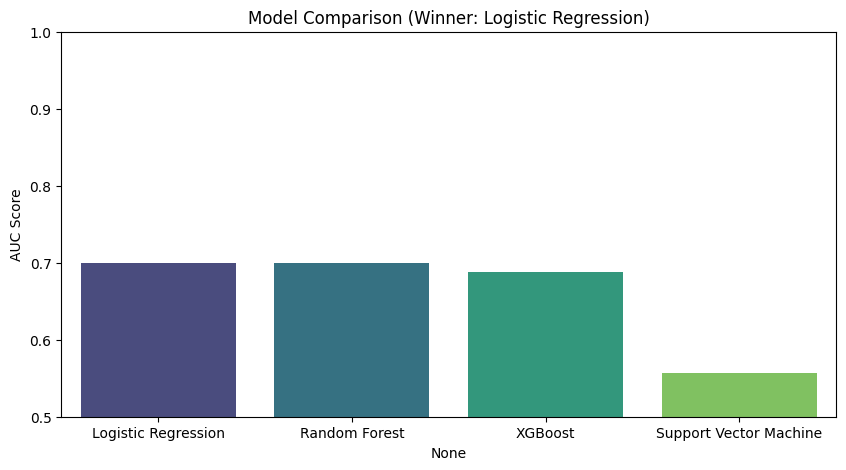

In [44]:
# Comparison & Selection

# Create a DataFrame of the results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="AUC", ascending=False)

print("Model Rankings:")
print(results_df)

# Dynamic Selection: Pick the model with the highest AUC score
best_model_name = results_df.index[0]
best_auc = results_df.iloc[0]['AUC']

print(f"\n CHAMPION MODEL: {best_model_name} with AUC: {best_auc:.4f}")

# Assign the champion model object based on the name
if best_model_name == "Logistic Regression":
    champion_model = lr_model
elif best_model_name == "Random Forest":
    champion_model = rf_model
elif best_model_name == "XGBoost":
    champion_model = xgb_model
else:
    champion_model = svm_model

# Plotting the comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df['AUC'], palette='viridis')
plt.title(f"Model Comparison (Winner: {best_model_name})")
plt.ylim(0.5, 1.0)
plt.ylabel("AUC Score")
plt.show()

### Feature Importance (Explainability)
Why did the model make these decisions?

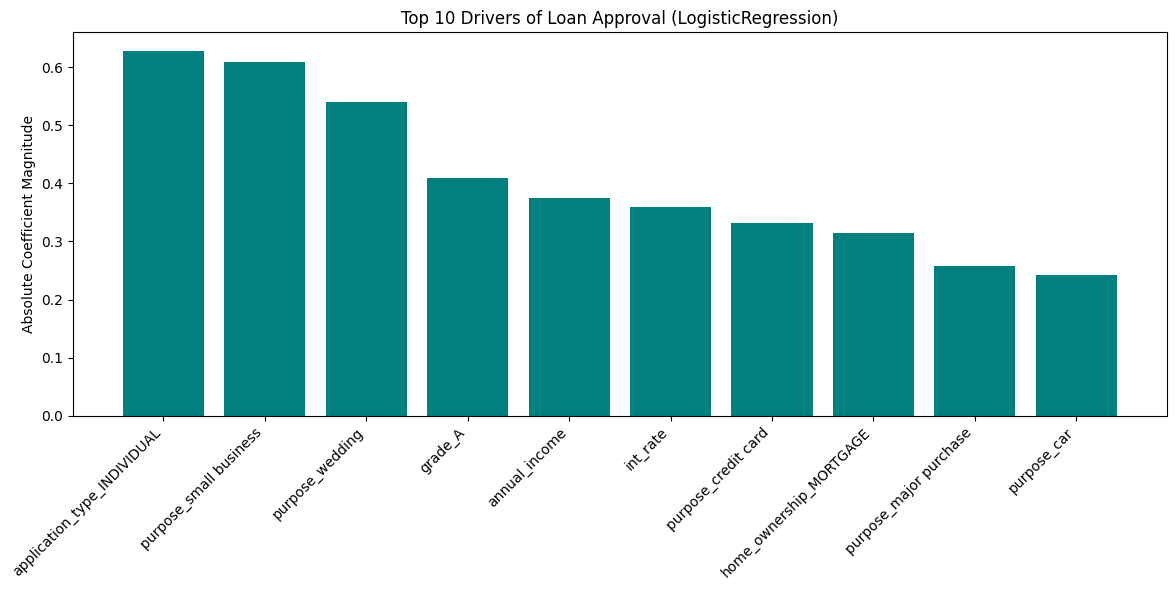

In [48]:
# Feature Importance / Coefficients

# xtract Feature Names
# We need to get the names from the OneHotEncoder to match the transformed data
ohe_feature_names = champion_model.named_steps['preprocessor'] \
                                  .named_transformers_['cat']['onehot'] \
                                  .get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names)

# 2. Get Importance or Coefficients based on model type
classifier = champion_model.named_steps['classifier']
model_type = type(classifier).__name__

if hasattr(classifier, 'feature_importances_'):
    # For Random Forest / XGBoost
    importances = classifier.feature_importances_
    metric_name = "Feature Importance"
    
elif hasattr(classifier, 'coef_'):
    # For Logistic Regression / SVM (Linear)
    # .coef_ returns a shape of (1, n_features), so we flatten it with [0]
    importances = np.abs(classifier.coef_[0]) 
    metric_name = "Absolute Coefficient Magnitude"

else:
    # Fallback for models like SVM with RBF kernel that don't offer direct importance
    print(f"Model {model_type} does not offer direct feature importance.")
    importances = np.zeros(len(all_feature_names))
    metric_name = "N/A"

# 3. Sort and Plot
indices = np.argsort(importances)[::-1] # Sort descending

plt.figure(figsize=(12, 6))
plt.title(f"Top 10 Drivers of Loan Approval ({model_type})")
plt.bar(range(10), importances[indices[:10]], align="center", color='teal')
plt.xticks(range(10), [all_feature_names[i] for i in indices[:10]], rotation=45, ha='right')
plt.ylabel(metric_name)
plt.tight_layout()
plt.show()

# Top 10 Drivers of Loan Approval (Logistic Regression)

The bar chart above visualizes the **feature importance** for a Logistic Regression model predicting loan approval. The importance is determined by the **absolute magnitude of the coefficients**. A higher bar indicates a stronger influence on the model's decision, regardless of whether that influence is positive (increasing approval odds) or negative (decreasing odds).

### Key Observations

**1. Application Type is the Strongest Predictor**
* **`application_type_INDIVIDUAL`:** This feature has the highest absolute coefficient (> 0.60), making it the single most influential factor in the model. This suggests that whether an application is individual (vs. joint) fundamentally changes the approval probability.

**2. Loan Purpose Matters Significantly**
* Several "Purpose" categories appear in the top 10, indicating the reason for the loan is critical:
    * **`purpose_small_business`:** The second strongest driver overall. Small business loans likely carry a distinct risk profile.
    * **`purpose_wedding`:** A surprisingly high-ranking factor, suggesting strong patterns in how wedding loans are adjudicated.
    * **`purpose_credit_card`**, **`purpose_major_purchase`**, **`purpose_car`:** These specific categories also play a major role in the decision boundary.

**3. Financial & Risk Metrics**
* **`grade_A`:** Being a top-tier credit grade is the 4th most important driver. This aligns with the expectation that creditworthiness is a primary filter.
* **`annual_income`:** Income is a top-5 driver, confirming that a borrower's raw earning power is heavily weighted.
* **`int_rate`:** The interest rate assigned is also a top driver, likely acting as a proxy for the lender's internal risk assessment.

---

### Summary for Analysis
The model is not just looking at raw numbers like income; it is heavily influenced by **categorical factors**—specifically *who* is applying (Individual) and *why* they are applying (Small Business, Wedding). This suggests that feature engineering around "Loan Purpose" and "Application Type" yields high value for this specific predictive task.

#### Cell 13: SHAP Explainability

SHAP values calculated successfully.


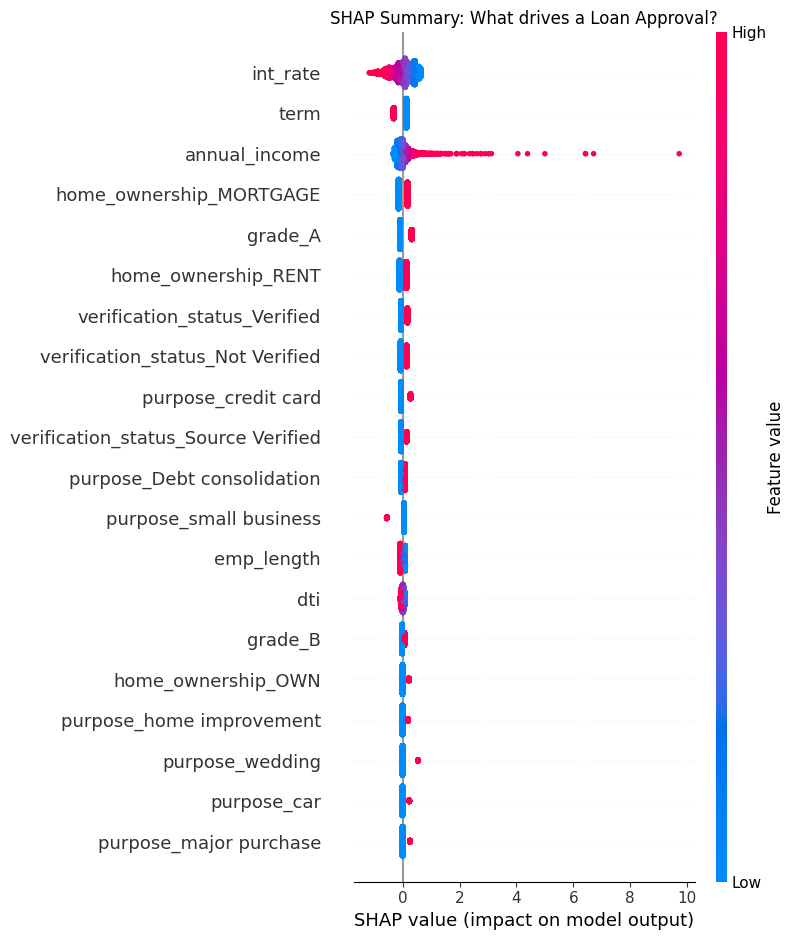

In [50]:
import shap

# REPARE THE DATA AND MODEL
# We need to feed SHAP the *transformed* data, not the raw text data.
# Extract the preprocessor and the classifier from our champion pipeline
preprocessor = champion_model.named_steps['preprocessor']
classifier = champion_model.named_steps['classifier']

# Transform the test set (or a sample of it to save time)
X_test_transformed = preprocessor.transform(X_test)

# 2. RECOVER FEATURE NAMES
# This is crucial so the plot shows "Grade=A" instead of "Column 15"
# Get names from the OneHotEncoder inside the pipeline
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names)

# 3. CALCULATE SHAP VALUES
# For Logistic Regression, we use LinearExplainer (very fast)
# We use a distinct background dataset (X_train summary) to serve as the baseline
X_train_transformed = preprocessor.transform(X_train)
explainer = shap.LinearExplainer(classifier, X_train_transformed, feature_perturbation="interventional")

# Calculate SHAP values for the Test Set
shap_values = explainer.shap_values(X_test_transformed)

print("SHAP values calculated successfully.")

# 4. GLOBAL INTERPRETABILITY (Summary Plot)
# This shows the most important features driving the "Approved" (1) decision.
plt.figure(figsize=(10, 8))
plt.title("SHAP Summary: What drives a Loan Approval?")
shap.summary_plot(shap_values, X_test_transformed, feature_names=all_feature_names, show=False)
plt.show()

# SHAP Summary: What drives a Loan Approval?

The SHAP summary plot above ranks the features by their importance in the predictive model. The y-axis lists the features in descending order of importance, while the x-axis (SHAP value) shows the impact on the model's output (Loan Approval).

* **Color:** represents the feature value (Red = High, Blue = Low).
* **Position:** represents the impact (Right = Positive impact/Higher likelihood, Left = Negative impact/Lower likelihood).

### Key Drivers

**1. Interest Rate (`int_rate`)**
* **Impact:** This is the most influential feature.
* **Direction:** The red dots (High Interest Rate) are clustered to the **left** (negative SHAP value), while blue dots (Low Interest Rate) are to the **right**.
* **Insight:** Higher interest rates strongly decrease the likelihood of loan approval (or are associated with the negative class), while lower rates increase the likelihood.

**2. Term (`term`)**
* **Impact:** The second most important feature.
* **Direction:** There is a clear separation. If `term` is high (Red, likely 60 months), it pushes the prediction to the left (negative). If `term` is low (Blue, likely 36 months), it pushes to the right.
* **Insight:** Short-term loans are more likely to be approved/positive than long-term loans.

**3. Annual Income (`annual_income`)**
* **Impact:** High impact with a long tail.
* **Direction:** The red dots (High Income) stretch far to the **right**.
* **Insight:** Having a high annual income is a massive driver for a positive outcome. The long tail indicates that for some "super-earners," income alone can almost guarantee a positive model score.

**4. Home Ownership (`home_ownership_MORTGAGE` vs `RENT`)**
* **Insight:** Being a mortgage holder (Red dots on `MORTGAGE`) has a positive impact (right side), while being a renter (Red dots on `RENT`) generally has a negative impact (left side). This confirms that owning a home (with a mortgage) is viewed as a stability factor.

**5. Grade A (`grade_A`)**
* **Insight:** Having a Grade of "A" (Red dots) has a strong positive impact on the model, pushing the prediction to the right.

---

### Summary for Analysis
The model is primarily driven by **cost and stability metrics**. The top predictors are the cost of the loan (Interest Rate, Term) and the financial stability of the borrower (Income, Home Ownership). This suggests the model is behaving logically: simpler, cheaper loans given to wealthy homeowners are the safest bets.

### Local Interpretability (Explain a Single Decision)
This eplains why a specific person was rejected or approved. It's powerful for the "Explain model decision" requirement.

Actual Status: Approved
Model Prediction Probability: 70.51%


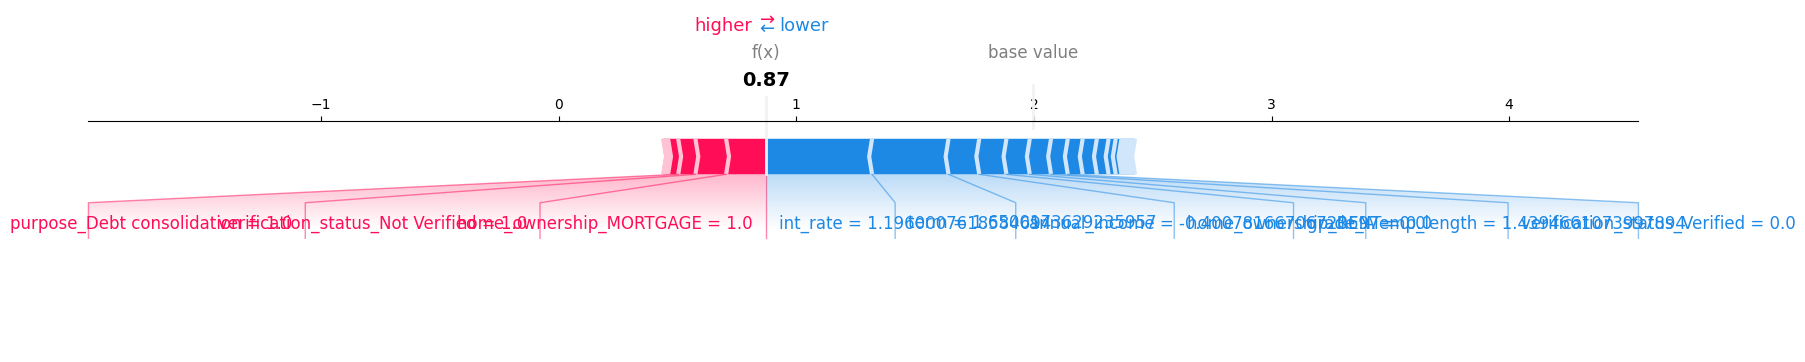

In [51]:
# Let's look at the first person in our test set
person_index = 0
person_data = X_test_transformed[person_index]

# Generate the Force Plot
# This shows how features pushed the probability Higher (Red) or Lower (Blue)
shap.initjs() # Initialize JavaScript for the plot

print(f"Actual Status: {'Approved' if y_test.iloc[person_index]==1 else 'Rejected'}")
print(f"Model Prediction Probability: {champion_model.predict_proba(X_test.iloc[[person_index]])[0][1]:.2%}")

# Force Plot
shap.force_plot(explainer.expected_value, 
                shap_values[person_index], 
                person_data, 
                feature_names=all_feature_names,
                matplotlib=True) # Use matplotlib=True for static notebook images

# SHAP Force Plot: Explanation of a Single Prediction

The visualization above is a **SHAP Force Plot**, which explains a single specific prediction made by the machine learning model. It breaks down how each feature contributed to moving the model's output from the "base value" (the average prediction) to the final prediction score ($f(x)$) of **0.87**.

### How to Read This Plot

* **Base Value:** The average model output over the training dataset. This is the starting point before any specific features are considered.
* **Final Prediction ($f(x) = 0.87$):** The actual score the model predicted for this specific borrower.
* **Red Bars (Higher):** Features that pushed the prediction **higher** (increasing the likelihood of the positive class/loan approval).
* **Blue Bars (Lower):** Features that pushed the prediction **lower** (decreasing the likelihood).

### Key Drivers for This Specific Prediction

**1. Positive Contributors (Pushing Score Up)**
* **`home_ownership_MORTGAGE = 1.0`:** The fact that this borrower has a mortgage is a strong positive signal, pushing the score significantly to the right.
* **`verification_status_Not Verified = 1.0`:** Surprisingly, this feature is pushing the score up. This might indicate that "Not Verified" loans in this specific dataset segment perform better or are associated with lower-risk products, or it could be interacting with other variables.
* **`purpose_Debt consolidation = 1.0`:** The purpose of the loan being for debt consolidation is contributing positively to the score.

**2. Negative Contributors (Pushing Score Down)**
* **`int_rate = 1.19...`:** The interest rate (likely normalized or transformed) is the strongest force pushing the score down. This suggests the rate is relatively high for this borrower, acting as a penalty.
* **`term = 0.6...`:** The loan term is also exerting downward pressure.
* **`annual_income = -0.0...`:** The income (which appears to be low or negative due to scaling/normalization) is slightly dragging the score down.

### Summary
For this specific applicant, the model started with a base expectation and was significantly encouraged by their **mortgage status** and **loan purpose**. However, these positive factors were heavily counteracted by the **interest rate** and **loan term**, resulting in a final score of **0.87**.

### Save Model

In [52]:
# Cell 12: Save Model
import joblib
joblib.dump(champion_model, 'loan_approval_pipeline.pkl')
print("Champion model saved successfully.")

Champion model saved successfully.
